# Трифонов Никита Дмитриевич

### trifonov28rus@gmail.com  
### tg: @qwertypine  

# TS Classification on Tiny Devices  
### Статья: https://vk.com/away.php?to=https%3A%2F%2Fvk.cc%2FarCcQr&cc_key= 

## Аннотация

В данной работе рассматривается новая модель классификации временных рядов, основаннная на рекуррентных нейронных сетях.  
Эта модель позволяет распараллелить вычисления и тем самым уменьшить вычислительну стоимость, что особо критично  
для устройств с ограниченными вычислительными ресурсами.

Ставилась задача классификации временных рядов, основной целью было повышение скорости работы модели, для того чтобы использовать в устройствах с низкой вычислительной мощностью.

## Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization
from time import *
from math import fabs
from scipy.stats import invgauss
import scipy
import random
import json
import math
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
%matplotlib inline

# задаем для воспроизводимости результатов
np.random.seed(42)

import filecmp
import os
import subprocess
import tempfile
import librosa
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytest
import seaborn as sb
import tqdm

Using TensorFlow backend.


# Описание датасета

## ESC: Dataset for Environmental Sound Classification

Набор данных ESC представляет собой набор коротких записей окружающей среды, доступных в унифицированном формате  
(5-секундные клипы, 44,1 кГц, одноканальный, Ogg Vorbis compressed @ 192 Кбит/с).

* ESC-50: маркированный набор из 2 000 записей окружающей среды (50 классов, 40 клипов на класс),  
* ESC-10: маркированный набор из 400 записей окружающей среды (10 классов, 40 клипов на класс) (это подмножество ESC-50)  

### Ссылка на датасет:  
https://vk.com/away.php?to=https%3A%2F%2Fvk.cc%2FarDp1D&cc_key=

Далее мы будем рассматривать набор $ESC-10$, чтобы сократить вычислительные расходы.

In [2]:
#работа с датасетом
df = pd.read_csv('/home/user/Programs/VK_test_task/Datasets/ESC-50-master/meta/esc50.csv', encoding = "ISO-8859-1")

In [3]:
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [4]:
esc10 = df[df['esc10']==True]

## Преобразуем аудиодорожки к FMCC (мел-частотным кепстральным коэффициентам)

Более подробный анализ признаков доступен по ссылке:  
https://nbviewer.jupyter.org/github/karoldvl/paper-2015-esc-dataset/blob/master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb

In [5]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled
    
    
# Load various imports 
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = '/home/user/Programs/VK_test_task/Datasets/ESC-50-master/audio/'

metadata = esc10

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = fulldatasetpath+str(row["filename"])
    
    class_label = row["category"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')


Finished feature extraction from  400  files


In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 


## Делим датасет на 2 кирпича

Для эффективного распараллеливания используется несколько входов для каждого из фрагментов данных.  
Фрагменты данных в статье называют кирпичами.  
$R$ - Рекуррентная НС со Swish функцией активации.

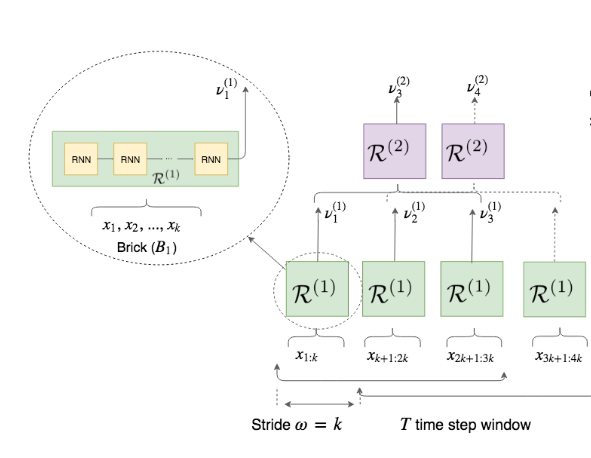

In [7]:
# split the dataset 
from sklearn.model_selection import train_test_split 

In [8]:
# Делим датасет на 2 набора данных по 6 и 7 признаков
x1_train, x1_test, y_train, y_test = train_test_split(X[:,:6], yy, test_size=0.2, random_state = 42)
x2_train, x2_test, y_train, y_test = train_test_split(X[:,6:], yy, test_size=0.2, random_state = 42)

## Построение модели

### Для начала реализуем Swish функцию активации

In [9]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [10]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

### Реализация ShaRNN

In [11]:
#Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import Conv1D, Reshape, MaxPooling1D, BatchNormalization

# first input model
brick1 = Input(shape=((1,x1_train.shape[1])))
RNN1 = SimpleRNN(6, activation='swish', input_shape=(1, x1_train.shape[1]))(brick1)



# second input model
brick2 = Input(shape = ((1, x2_train.shape[1])))
RNN2 = SimpleRNN(7, activation='swish', input_shape=(1, x2_train.shape[1]))(brick2)



# merge input models
merge = concatenate([RNN1, RNN2])


# interpretation model
output = Dense(10, activation='softmax')(merge)

model1 = Model(inputs=[brick1, brick2], outputs=output)

# summarize layers
print(model1.summary())


# plot graph
#plot_model(model, to_file='multiple_inputs.png')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 6)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 7)         0                                            
__________________________________________________________________________________________________
simple_rnn_1 (SimpleRNN)        (None, 6)            78          input_1[0][0]                    
__________________________________________________________________________________________________
simple_rnn_2 (SimpleRNN)        (None, 7)            105         input_2[0][0]                    
____________________________________________________________________________________________

### Решейпинг данных

In [12]:
x_train1 = x1_train.reshape(-1, 1, 6)
x_train2 = x2_train.reshape(-1, 1, 7)

x_test1 = x1_test.reshape(-1, 1, 6)
x_test2 = x2_test.reshape(-1, 1, 7)

y_train_t = y_train.reshape(-1, 1, 10)
y_test_t = y_test.reshape(-1, 1, 10)

### Обучение модели

In [13]:
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [14]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy',
                                        mode='max',
                                        patience=200,
                                        verbose=1)
    
chkpt = ModelCheckpoint(filepath='/home/user/Programs/VK_test_task/Models/ShaRNN.hdf5',
                        monitor='val_accuracy', 
                        verbose=1, 
                        save_best_only=True, 
                        mode='max')

callbacks = [early_stopping_callback, chkpt]

In [ ]:
history1 = model1.fit([x_train1, x_train2],
                     y_train,
                     validation_data=([x_test1,x_test2], y_test),
                     epochs =2000,
                     #callbacks=callbacks
                    )

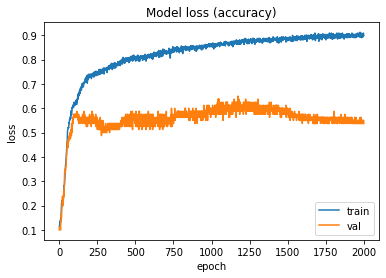

In [16]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model loss (accuracy)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')


plt.show()

In [17]:
print('лучшее значение accuracy = ', max(history1.history['val_accuracy']), ' (на валидационном наборе)')

лучшее значение accuracy =  0.6499999761581421  (на валидационном наборе)


In [18]:
%timeit model1.predict([x_test1,x_test2])

1.43 ms ± 56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Персептрон

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [20]:
model2 = Sequential()
model2.add(Dense(16, input_dim=(len(x_train[0])), activation='sigmoid')) 
model2.add(Dense(10, activation='softmax')) # не используем функции активации

In [21]:
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
history2 = model2.fit(x_train, y_train, batch_size=1, epochs=250, validation_data=(x_test, y_test),  verbose=1)

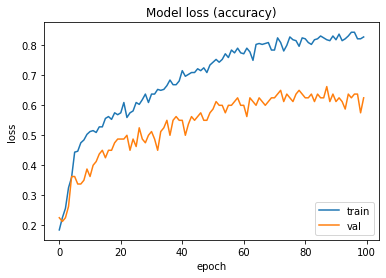

In [23]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model loss (accuracy)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')


plt.show()

In [24]:
%timeit model2.predict(x_test)

829 µs ± 87.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
print('лучшее значение accuracy = ', max(history2.history['val_accuracy']), ' (на валидационном наборе)')

лучшее значение accuracy =  0.6625000238418579  (на валидационном наборе)


## LSTM

In [26]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

In [27]:
model3 = Sequential()
model3.add(LSTM(13, input_shape=(1, X.shape[1])))
model3.add(Dense(10, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
x_train_lstm = x_train.reshape(-1, 1, 13)
x_test_lstm = x_test.reshape(-1, 1, 13)


In [ ]:
history3 = model3.fit(x_train_lstm, y_train, epochs=250, batch_size=1, verbose=1, validation_data=(x_test_lstm, y_test))

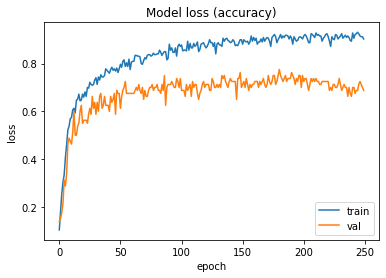

In [30]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model loss (accuracy)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')


plt.show()

In [31]:
%timeit model3.predict(x_test_lstm)

1.95 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
print('лучшее значение accuracy = ', max(history3.history['val_accuracy']), ' (на валидационном наборе)')

лучшее значение accuracy =  0.7749999761581421  (на валидационном наборе)


# Основные итоги и вывод

### Дисклеймер

Данная работа выполнена во время напряженной сессии, поэтому здесь не будет глубокого исследования и данную работу  
следует воспринимать как Baseline.

### Результаты

Параметр                  | ShaRNN          | Perceptron       | LSTM        
-------------             | ----------------| ---------------- | -------------
Время  (для предсказания) | 1.43 ms ± 56 µs | 829 µs ± 87.7 µs | 1.95 ms ± 159 µs
Точность, %               | 0.65            | 0.66             | 0.75
Время/шаг                 | ~ 80 µs         | ~1ms             | ~2ms

Таким образом, самый точный результат у LSTM, но самое долгое по времени обучение.  
ShaRNN позволяет обучать модели в несколько раз быстрее и при этом выдает точность сопоставимую с персептроном. 

Данную модель (ShaRNN) можно использовать в тех ситуациях, когда нам важна быстрая скорость обучения.

### Критика и дальнейшие перспективы

В качестве дальнейших исследований, можно учесть:

1) Выбрать датасет большей длины, здесь 13 признаков, выделенным при помощи FMCC, в оригинальных работах около 100 признаков;  
2) Выбрать датасет с бОльшим числом примеров и разделить его на тренировочную, проверочную и тестовую части,  
   обучить несколько моделей и статистику усреднить;  
3) Рассчитать производительность во Flops'ах;  
4) Использовать callback при обучении моделей;  
5) Произвести оптимизацию гиперпараметров.